# Algorithm 2 - PageRank

## Step 1 - Library and Function Setup

In [1]:
import neo4j
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j", "ucb_mids_w205"))
session = driver.session(database="neo4j")

In [3]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

## Step 2 - PageRank Value Calculations

In [4]:
query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Country', 'IMPORTS_FROM', {relationshipProperties: 'weight_kg'})"
session.run(query)

In [5]:
query = """

CALL gds.pageRank.stream('ds_graph',
                        {maxIterations: $max_iterations,
                        dampingFactor: $damping_factor})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS CountryCode, score AS PageRank

ORDER BY PageRank DESC, CountryCode ASC

"""

max_itr = 20
d_factor = 0.05

pr_scores = my_neo4j_run_query_pandas(query, max_iterations = max_itr, damping_factor = d_factor)

# Find the top 10 importers
top_10 = pr_scores.head(10)
top_10

,CountryCode,PageRank
0,US,1.440260
1,CH,1.379540
2,FR,1.328069
3,ZA,1.297066
4,IT,1.293862
5,DE,1.274501
6,TH,1.271938
7,NL,1.241379
8,CA,1.201414
9,ZW,1.166457


## Step 3 - Visualization for Top 10 Illegal Ivory Importers

In [6]:
# Create a country name map for visualization
country_map = {'US': 'United States',
               'CH': 'Switzerland',
               'FR': 'France',
               'ZA': 'South Africa',
               'IT': 'Italy',
               'DE': 'Germany',
               'TH': 'Thailand',
               'NL': 'Netherlands',
               'CA': 'Canada',
               'ZW': 'Zimbabwe'}

# Top 10 countries data frame (CountryCode, PageRank, CountryName)
top_10['CountryName'] = top_10['CountryCode'].map(country_map)
top_10

/tmp/ipykernel_182/2082689364.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['CountryName'] = top_10['CountryCode'].map(country_map)


,CountryCode,PageRank,CountryName
0,US,1.440260,United States
1,CH,1.379540,Switzerland
2,FR,1.328069,France
3,ZA,1.297066,South Africa
4,IT,1.293862,Italy
5,DE,1.274501,Germany
6,TH,1.271938,Thailand
7,NL,1.241379,Netherlands
8,CA,1.201414,Canada
9,ZW,1.166457,Zimbabwe


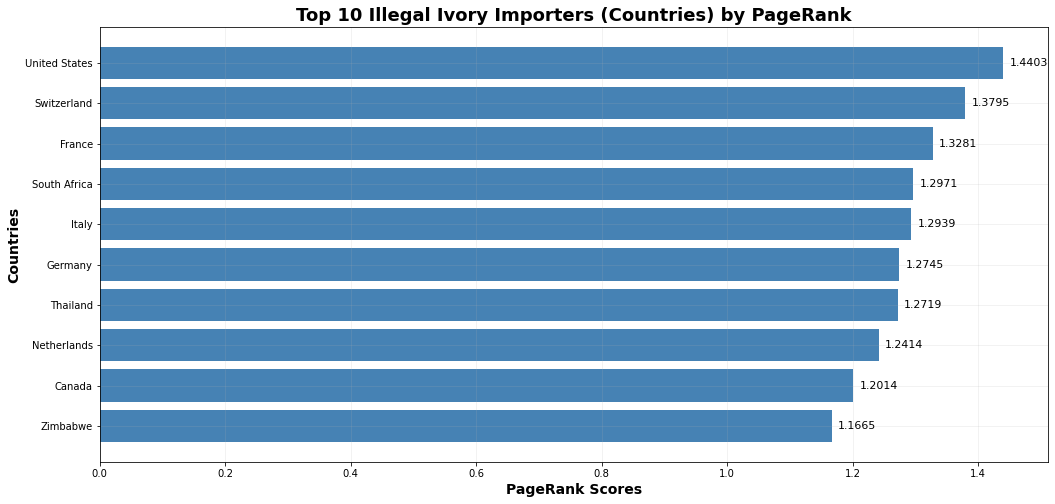

In [7]:
# Display the max on the top
top_10 = top_10.sort_values(by = 'PageRank', ascending = True)

fig, ax = plt.subplots(figsize = (17,8))

# horizontal bar graphs
bars = ax.barh(top_10['CountryName'], top_10['PageRank'], color = 'steelblue')

ax.set_title('Top 10 Illegal Ivory Importers (Countries) by PageRank', fontsize = 18, fontweight = 'bold')
ax.set_xlabel('PageRank Scores', fontsize = 14, fontweight = 'bold')
ax.set_ylabel('Countries', fontsize = 14, fontweight = 'bold')

# Display PageRank values
for bar in bars:
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.4f}', va = 'center', fontsize = 11)

# Blur the grids 
ax.xaxis.grid(True, alpha = 0.2)
ax.yaxis.grid(True, alpha = 0.2)

plt.show()

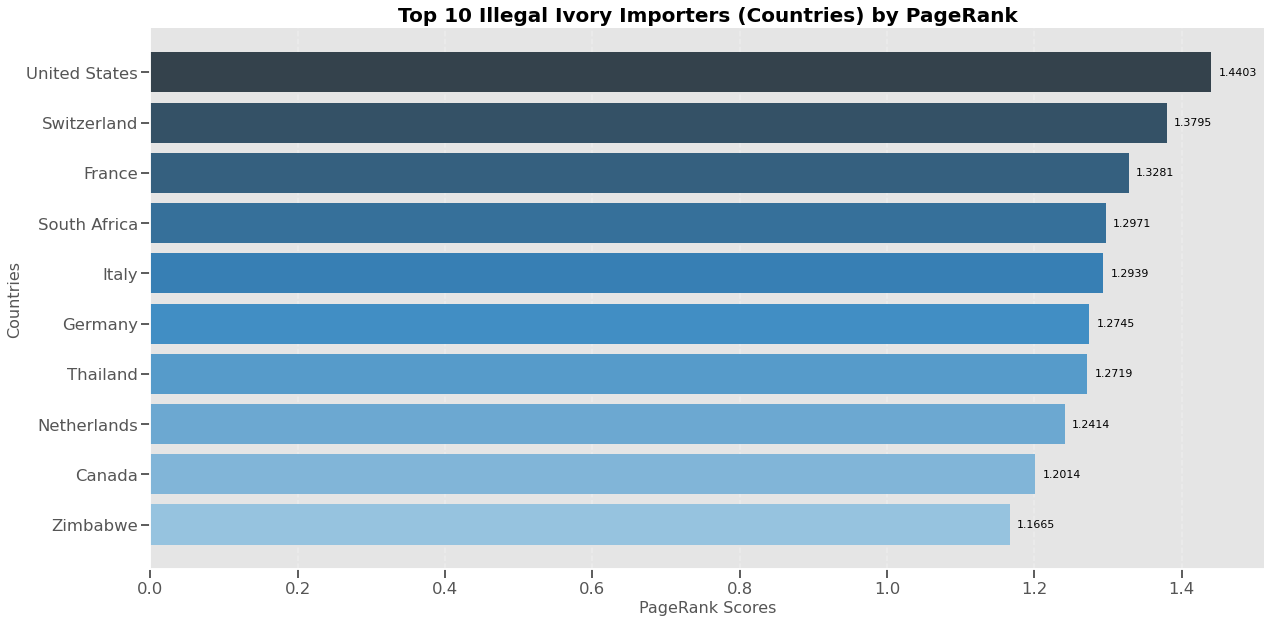

In [14]:
# Display the max on the top
top_10 = top_10.sort_values(by='PageRank', ascending=True)

plt.style.use('ggplot')
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(17, 8))

# horizontal bar graphs using seaborn
colors = sns.color_palette('Blues_d', len(top_10))
bars = ax.barh(top_10['CountryName'], top_10['PageRank'], color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Top 10 Illegal Ivory Importers (Countries) by PageRank',
             fontsize=20, fontweight='bold')
ax.set_xlabel('PageRank Scores', fontsize=16)
ax.set_ylabel('Countries', fontsize=16)

# Display PageRank values
for bar in bars:
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.4f}', va = 'center', fontsize = 11)

# Blur the grids 
ax.xaxis.grid(True, linestyle='--', alpha=0.3)
ax.yaxis.grid(False)

plt.tight_layout()
plt.show()